# Research question 7

### How do movie endings vary by film length ? This question would explore whether movies of different lengths (e.g., short vs. feature-length) tend to have different types of endings.

This notebook presents initial observations and is not intended to represent the final conclusions.

##### Importations

In [1]:
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import kstest
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [11]:
# path
DATA_FOLDER = '../../src/data/'
MOVIE_DATASET = DATA_FOLDER + 'movies_dataset_final_2.tsv'

# Dataset loading
movies = pd.read_csv(MOVIE_DATASET, sep='\t')

In [12]:
movies.columns

Index(['Movie_ID', 'Other_Column', 'Title', 'Release_Date', 'Runtime',
       'Languages', 'Country', 'Genres', 'Summary', 'Score', 'director',
       'vote_average', 'revenue', 'collection', 'budget', 'productions'],
      dtype='object')

### Remove the missing values

In [14]:
# Count the number of NaN values in the 'run_time' column
nan_count = movies['Runtime'].isna().sum()

# Print the count of NaN values
print(f"Number of NaN values in 'run_time': {nan_count}")

Number of NaN values in 'run_time': 1543


In [15]:
# Convert 'run_time' in numeric to avoir errors 
movies['Runtime'] = pd.to_numeric(movies['Runtime'], errors='coerce')

# Delete rows where 'run_time' is NaN or <= 0
movies_cleaned = movies.dropna(subset=['Runtime'])
movies_cleaned = movies_cleaned[movies_cleaned['Runtime'] > 0]

print(f"Number of movies after deleting : {movies_cleaned.shape[0]}")

Number of movies after deleting : 17833


### Statistics

We have chosen 40 minutes as the threshold to differentiate between short and long movies. However, this number will be refined later. For now, it serves as a preliminary value to ensure we can perform initial observations.
However, this number will be refined later based on the actual distribution of movie durations in the dataset. A more nuanced categorization could also be considered, such as dividing movies into multiple ranges (e.g., 0-40 minutes, 40-90 minutes, 90-120 minutes, etc.) for more detailed analysis.

In [16]:
# Group by categories
movies_cleaned['duration_category'] = movies_cleaned['Runtime'].apply(lambda x: 'Short' if x < 40 else 'Feature-length')

In [19]:
# Calculate descriptive statistics (mean, median, std) for each duration category
group_stats = movies_cleaned.groupby('duration_category')['Score'].agg(['mean', 'median', 'std'])

# Print the result in a formatted way
print("Descriptive Statistics by Duration Category:")
print(group_stats.to_string(index=True, float_format="{:.2f}".format))


Descriptive Statistics by Duration Category:
                   mean  median  std
duration_category                   
Feature-length     0.06    0.05 0.18
Short              0.04    0.03 0.20


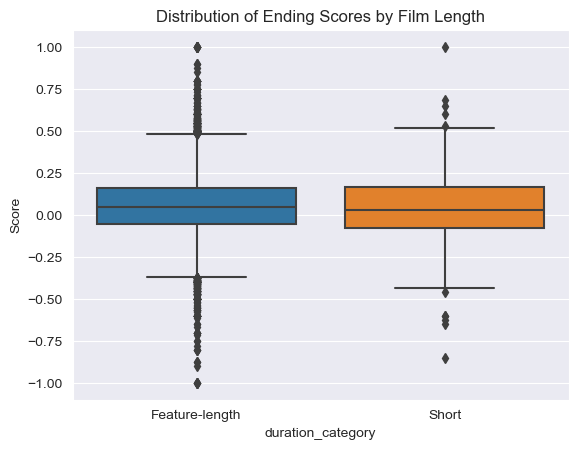

In [21]:
# Boxplot
sns.boxplot(data=movies_cleaned, x='duration_category', y='Score')
plt.title('Distribution of Ending Scores by Film Length')
plt.show()


### Test if the distributions are normal 

In [23]:
# Filter scores for short movies
short_scores = movies_cleaned[movies_cleaned['duration_category'] == 'Short']['Score']

# Filter scores for feature-length movies
feature_scores = movies_cleaned[movies_cleaned['duration_category'] == 'Feature-length']['Score']


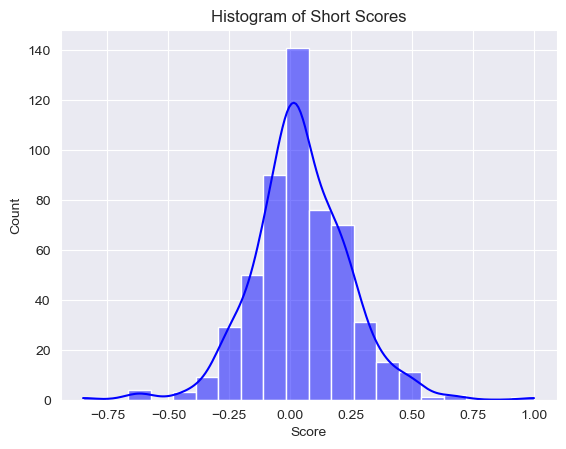

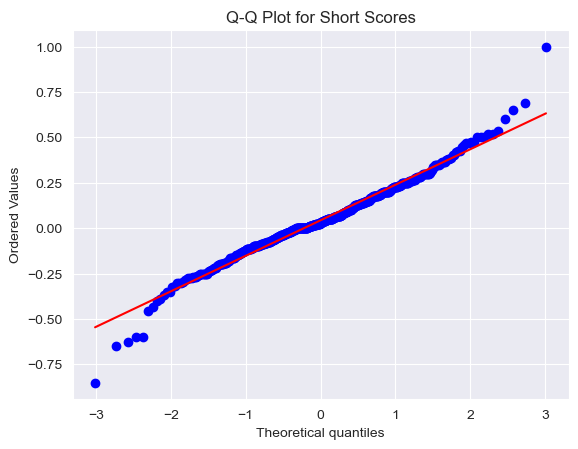

In [25]:

sns.histplot(short_scores, kde=True, bins=20, color='blue')
plt.title("Histogram of Short Scores")
plt.show()

# Q-Q Plot
stats.probplot(short_scores, dist="norm", plot=plt)
plt.title("Q-Q Plot for Short Scores")
plt.show()

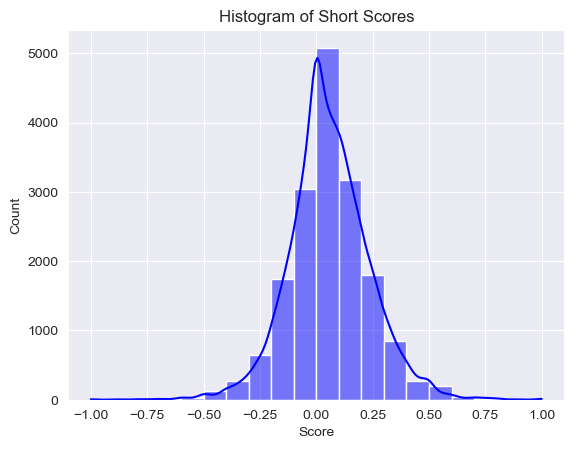

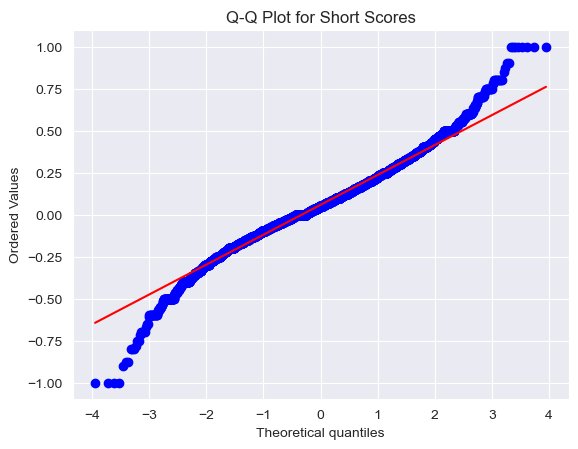

In [27]:
sns.histplot(feature_scores, kde=True, bins=20, color='blue')
plt.title("Histogram of Short Scores")
plt.show()

# Q-Q Plot
stats.probplot(feature_scores, dist="norm", plot=plt)
plt.title("Q-Q Plot for Short Scores")
plt.show()

The Kolmogorov-Smirnov (KS) Test is commonly used for larger datasets because it is a non-parametric test that compares the observed cumulative distribution function (CDF) of a sample with the expected CDF of a normal distribution. Unlike the Shapiro-Wilk test, which is better suited for smaller datasets, the KS test is more reliable and efficient for large samples since it does not assume any specific distribution shape and is less sensitive to the influence of large sample sizes. 

In [28]:

stat, p = kstest(short_scores, 'norm', args=(short_scores.mean(), short_scores.std()))
print(f"KS Test: statistic={stat:.4f}, p-value={p:.4f}")

if p > 0.05:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")
from scipy.stats import kstest

stat, p = kstest(short_scores, 'norm', args=(feature_scores.mean(), short_scores.std()))
print(f"KS Test: statistic={stat:.4f}, p-value={p:.4f}")

if p > 0.05:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")


KS Test: statistic=0.0536, p-value=0.0895
The data follows a normal distribution (fail to reject H0).
KS Test: statistic=0.0829, p-value=0.0012
The data does not follow a normal distribution (reject H0).


The Mann-Whitney U test is used when comparing two independent groups, especially when the data does not follow a normal distribution or when the assumptions of the t-test (e.g., normality and homogeneity of variance) are violated. It is a non-parametric test that evaluates whether the distributions of the two groups are different by comparing the ranks of the values.

In [31]:

# Test Mann-Whitney U
u_stat, p_value_u = mannwhitneyu(short_scores, feature_scores)

from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test to compare 'short_scores' and 'feature_scores'
u_stat, p_value_u = mannwhitneyu(short_scores, feature_scores)

# Print the results of the test
print(f"Mann-Whitney U Test Results:\nU-statistic: {u_stat:.4f}\np-value: {p_value_u:.4f}")

# Interpretation based on p-value
if p_value_u < 0.05:
    print("The distributions of short and feature-length films' scores are significantly different (reject H0).")
else:
    print("There is no significant difference between the distributions of short and feature-length films' scores (fail to reject H0).")


Mann-Whitney U Test Results:
U-statistic: 4405812.5000
p-value: 0.0345
The distributions of short and feature-length films' scores are significantly different (reject H0).
